In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h3>Loading Data-Train and test csv files</h3>

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Instacart/train.csv')  #train 
train.head()

,Unnamed: 0,user_id,order_hour_of_day,days_since_prior_order,Total orders,user_re_ratio,user_ntre_ratio,product_id,user_prd_re_ratio,times_cart_123,times_prd_last_5,prd_cart_last_5,prd_ntre_ratio,dow_re_ratio,dow_ntre_ratio,reordered
0,0,1,8,14.0,10,0.694915,0.305085,196,1.000000,9.0,5.0,6.4,0.223520,0.727273,0.409021,1.0
1,1,1,8,14.0,10,0.694915,0.305085,10258,1.000000,7.0,5.0,4.4,0.286228,0.727273,0.409021,1.0
2,2,1,8,14.0,10,0.694915,0.305085,10326,0.166667,0.0,0.0,2.6,0.347991,0.727273,0.409021,0.0
3,3,1,8,14.0,10,0.694915,0.305085,12427,1.000000,8.0,5.0,2.6,0.259265,0.727273,0.409021,0.0
4,4,1,8,14.0,10,0.694915,0.305085,13032,0.333333,0.0,2.0,1.4,0.342842,0.727273,0.409021,1.0


**Dropping not required features**

In [ ]:
train.drop(['Unnamed: 0','order_hour_of_day','days_since_prior_order'],axis=1,inplace=True)

In [ ]:
train.shape

(8474661, 13)

<h3>droping class label:reordered from train and saving as y

In [ ]:
y=train['reordered']     #class label for train data
x=train.drop(['reordered'],axis=1)    #removing class labels from train data
y.head(2)

0    1.0
1    1.0
Name: reordered, dtype: float64

In [ ]:
y.value_counts()  #imbalance dataset

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

**=>IMBALANCE DATASET**

<h2> Splitting  Train data into Train and cross validation: Stratified Sampling</h2>

In [ ]:
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.33, random_state=20,stratify=y)    #train, cv for random cv

Note: Since our final model is lgbm which is tree-based model hence no need to encode numerical features using Min-max scalar here, willn't effect result.

<h3>resetting index to user_id and product_id</h3>

In [ ]:
x_train=x_train.set_index(['user_id','product_id'])
x_train.head()

,,Total orders,user_re_ratio,user_ntre_ratio,user_prd_re_ratio,times_cart_123,times_prd_last_5,prd_cart_last_5,prd_ntre_ratio,dow_re_ratio,dow_ntre_ratio
user_id,product_id,,,,,,,,,,
4427,14493,41,0.586466,0.413534,0.285714,0.0,1.0,12.2,0.330286,0.529730,0.409021
94944,21301,14,0.405405,0.594595,0.100000,0.0,0.0,8.4,0.407595,0.508772,0.409021
36941,13984,18,0.747126,0.252874,0.200000,1.0,1.0,13.4,0.453178,0.761905,0.425631
122938,39408,19,0.500000,0.500000,0.625000,2.0,3.0,3.2,0.375571,0.526316,0.410229
42168,14992,4,0.357143,0.642857,0.500000,0.0,1.0,6.8,0.417180,0.000000,0.414724


In [ ]:
x_cv=x_cv.set_index(['user_id','product_id'])
x_cv.head()

,,Total orders,user_re_ratio,user_ntre_ratio,user_prd_re_ratio,times_cart_123,times_prd_last_5,prd_cart_last_5,prd_ntre_ratio,dow_re_ratio,dow_ntre_ratio
user_id,product_id,,,,,,,,,,
57226,40759,47,0.442997,0.557003,0.023256,0.0,0.0,7.8,0.512012,0.333333,0.414724
41944,25533,24,0.747312,0.252688,0.363636,2.0,1.0,2.8,0.297915,0.888889,0.396157
165823,30489,15,0.525180,0.474820,0.200000,1.0,1.0,11.0,0.275177,0.444444,0.414724
36400,25767,99,0.626466,0.373534,0.018182,0.0,0.0,8.2,0.389831,0.780488,0.413728
146729,37825,5,0.340909,0.659091,1.000000,0.0,1.0,10.8,0.473805,0.363636,0.414724


**Train and saving final model-LGBM**

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 22193, done.
remote: Counting objects: 100% (941/941), done.
remote: Compressing objects: 100% (560/560), done.
remote: Total 22193 (delta 588), reused 609 (delta 363), pack-reused 21252
Receiving objects: 100% (22193/22193), 17.48 MiB | 29.94 MiB/s, done.
Resolving deltas: 100% (16154/16154), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused

In [ ]:
! cd /content/LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1  ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
#fitting model with best param
from lightgbm import LGBMClassifier
lgbm=LGBMClassifier(device_type='gpu',class_weight={0:1,1:5},learning_rate=0.1,max_depth=5,n_estimators=200)
lgbm.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 5},
               colsample_bytree=1.0, device_type='gpu', importance_type='split',
               learning_rate=0.1, max_depth=5, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#saving model
with open('/content/drive/MyDrive/Instacart/model.sav','wb') as file:
  pickle.dump(lgbm,file)

In [ ]:
from sklearn.metrics import f1_score
y_tr_pred=lgbm.predict(x_train)
tr_f1=f1_score(y_tr_pred,y_train)
print('f1 score for train:',tr_f1)

f1 score for train: 0.42332232464727887


In [ ]:
y_cv_pred=lgbm.predict(x_cv)
cv_f1=f1_score(y_cv_pred,y_cv)
print('f1 score for cv:',cv_f1)

f1 score for cv: 0.4228324287058868


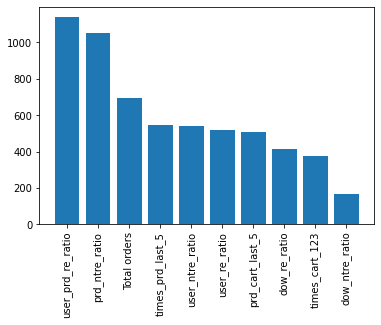

In [ ]:
#feature importance
imp=lgbm.feature_importances_
#sort feature importance in desc order
indices=np.argsort(imp)[::-1]
feature_names=x_train.columns
#rearrange feature names to match importances
name=[feature_names[i] for i in indices]
#barplot
plt.bar(range(len(indices)),imp[indices])
plt.xticks(range(len(indices)),name)
plt.xticks(rotation='vertical')
plt.show()